In [1]:
import shutil
import urllib.request as request
from contextlib import closing
import zipfile
import os
import pandas as pd
import glob
from wetterdienst import Wetterdienst
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

INFO: Wetterdienst cache directory is /home/derwer/.cache/wetterdienst


In [2]:
# only apply changes here....

# Whats your location...

latitude = 49.34528
longitude = 9.97944


In [3]:
# some variables... those hopefully dont change very often ;)

# url of the ftp server
# xxxx is replaced by numbers defined in vals
url="""ftp://opendata.dwd.de/climate_environment/CDC/grids_germany/return_periods/precipitation/KOSTRA/KOSTRA_DWD_2010R/asc/StatRR_KOSTRA-DWD-2010R_Dxxxx.csv.zip"""
vals = [5,10,20,30,45,60,90,120,180,240,360,540,720,1080,1440,2880,4320]
# length of number includin pre-zeros
# example: 
# val = 5
# vallen = 5
# then xxxx is replaced wit 00005
vallen = 4

# name of vals in dataframe
valname = "precipitation_time / min"
# path where the FTP-server downloads are copied to
datapath = "data"
# index/column-name of weather station in files from FTP
index = "INDEX_RC"

In [4]:
def get_ftp(url,path="",rm=True):
    if path:
        file = "/".join( (path,url.split("/")[-1] ) )
    else:
        file=url.split("/")[-1]
    try:
        with closing(request.urlopen(url)) as r:
            with open(file, 'wb') as f:
                shutil.copyfileobj(r, f)
        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall(path)
        if rm:
            os.system( "rm "+file )
        return file.replace(".zip","")
    except:
        return None

    
def get_stations(latitude,longitude,path="",distance=30):
    API = Wetterdienst("dwd", "observation")
    stations = API(
        parameter=["precipitation_height"],
        resolution="minute_1",)#.filter_by_station_id(station_id=list(range(10000) ) )
    df = stations.filter_by_station_id(station_id=list(range(10000) ) ).df

    yi = "latitude"
    xi = "longitude"
    zi = "height"

    points = sns.scatterplot(data=df, x=xi, y=yi, hue=zi, )

    ratio = ( df[xi].max()-df[xi].min() )/(df[yi].max()-df[yi].min() )    

    #s = (49.34528, 9.97944)
    df = stations.filter_by_distance(latitude=latitude,longitude=longitude,distance=distance,unit="km").df
    sns.scatterplot(data=df, x=xi, y=yi, color="green") 

    plt.plot(longitude,latitude,".r",markersize=10)    

    grid_id = df["station_id"][0]
    if path:    
        path = "/".join( (path,str(grid_id) ) )
    else:
        path = str(grid_id) 
    
    plt.xlabel(xi)
    plt.ylabel(yi)
    plt.gca().set_aspect(ratio)
    #plt.gca().set_aspect('equal')#, adjustable='box')
    plt.savefig(path+"_stations.png")
    plt.savefig(path+"_stations.pdf")
    plt.show()
    plt.close()

    for key in df:
        if "date" in key:
            df[key] = df[key].astype(str).str[:-6]
    
    #df.to_csv('stations_1.csv')
    df.to_excel(path+'_stations.xlsx')
    df.head()
    
    return grid_id
    
    


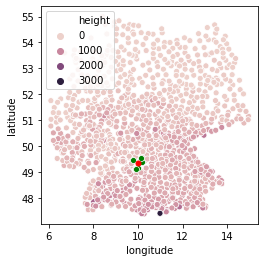

In [5]:
# get your station
grid_id = get_stations(latitude,longitude)

In [6]:
# get FTP data
try:
    os.mkdir(datapath)
except:
    None

# kinda hard code :/
files = []
for i in vals:
    i = str(i)
    x = ( vallen-len(i) )*"0" + i
    xx = url.replace("xxxx",x)
    path = get_ftp( xx, path=datapath )
    print(xx)
    files.append(path)

ftp://opendata.dwd.de/climate_environment/CDC/grids_germany/return_periods/precipitation/KOSTRA/KOSTRA_DWD_2010R/asc/StatRR_KOSTRA-DWD-2010R_D0005.csv.zip
ftp://opendata.dwd.de/climate_environment/CDC/grids_germany/return_periods/precipitation/KOSTRA/KOSTRA_DWD_2010R/asc/StatRR_KOSTRA-DWD-2010R_D0010.csv.zip
ftp://opendata.dwd.de/climate_environment/CDC/grids_germany/return_periods/precipitation/KOSTRA/KOSTRA_DWD_2010R/asc/StatRR_KOSTRA-DWD-2010R_D0020.csv.zip
ftp://opendata.dwd.de/climate_environment/CDC/grids_germany/return_periods/precipitation/KOSTRA/KOSTRA_DWD_2010R/asc/StatRR_KOSTRA-DWD-2010R_D0030.csv.zip
ftp://opendata.dwd.de/climate_environment/CDC/grids_germany/return_periods/precipitation/KOSTRA/KOSTRA_DWD_2010R/asc/StatRR_KOSTRA-DWD-2010R_D0045.csv.zip
ftp://opendata.dwd.de/climate_environment/CDC/grids_germany/return_periods/precipitation/KOSTRA/KOSTRA_DWD_2010R/asc/StatRR_KOSTRA-DWD-2010R_D0060.csv.zip
ftp://opendata.dwd.de/climate_environment/CDC/grids_germany/return_per

In [7]:
# build what you need...

# for stabillity reasons:
# ...but hard code :/
files = sorted(glob.glob(datapath+"/*.csv"))
vals  = [ f.split(".")[-2].split("D")[-1] for f in files ]

collection = []

for i,file in zip(vals,files):
    df = pd.read_csv(file,delimiter=";").set_index(index)
    #df.head()
    #display(df.iloc[grid_id])
    goal   = df.iloc[int(grid_id)]
    #goal[valname] = i
    collection.append( goal )

df = pd.DataFrame(collection, columns=df.columns)    
df[valname] = vals
df = df.set_index(valname)
#result = pd.concat( collection )

df.to_excel(grid_id+"_data.xlsx")
df

,HN_001A,HN_002A,HN_003A,HN_005A,HN_010A,HN_020A,HN_030A,HN_050A,HN_100A
precipitation_time / min,,,,,,,,,
0005,4.9,6.3,7.1,8.1,9.5,11.0,11.8,12.8,14.2
0010,7.6,9.6,10.7,12.2,14.1,16.1,17.2,18.7,20.6
0020,10.6,13.4,14.9,16.9,19.6,22.3,23.9,25.9,28.6
0030,12.3,15.5,17.5,19.9,23.1,26.4,28.3,30.7,34.0
0045,13.7,17.6,19.9,22.8,26.8,30.7,33.0,36.0,39.9
0060,14.5,19.0,21.7,25.0,29.5,34.0,36.7,40.0,44.5
0090,15.8,20.5,23.3,26.7,31.4,36.1,38.9,42.4,47.1
0120,16.8,21.6,24.5,28.0,32.9,37.7,40.6,44.1,49.0
0180,18.3,23.3,26.3,30.0,35.1,40.1,43.1,46.8,51.9


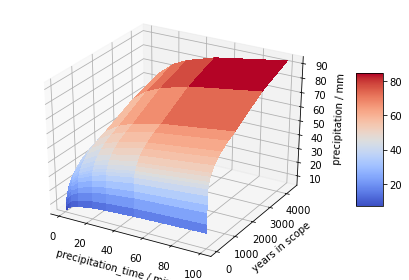

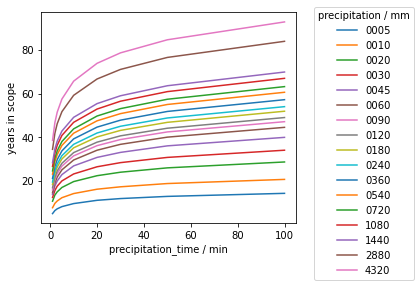

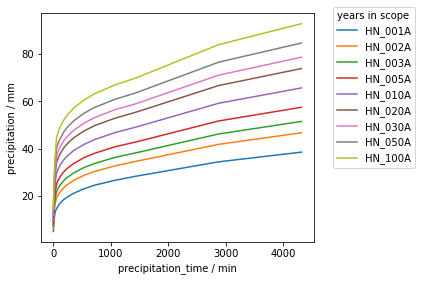

In [10]:
def plot_output(df,path):
    
    Z = df.to_numpy()
    x = [ int(''.join(x for x in r if x.isdigit()) ) for r in df.columns ]
    y = [ int(''.join(x for x in r if x.isdigit()) ) for r in df.index ]
    X, Y = np.meshgrid(np.arange(len(x)), np.arange(len(y)))
    X, Y = np.meshgrid(x,y)

    from matplotlib import cm

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel(valname)
    ax.set_ylabel("years in scope")
    ax.set_zlabel("precipitation / mm")

    plt.tight_layout()
    plt.savefig(path+"_surf.png")
    plt.savefig(path+"_surf.pdf")
    plt.show()
    plt.close()

    for index, row in df.iterrows():
        plt.plot(x,row,label = index)
        #df.iloc[int(grid_id)]

    plt.ylabel("years in scope")
    plt.xlabel(valname)
    plt.legend(title="precipitation / mm",bbox_to_anchor = (1.05, 1.05))   
    plt.tight_layout()
    plt.savefig(path+"_years.png")
    plt.savefig(path+"_years.pdf")
    plt.show()
    plt.close()


    for i in df.columns:
        plt.plot(y,df[i],label = i)
        #df.iloc[int(grid_id)]

    plt.ylabel("precipitation / mm")
    plt.xlabel(valname)
    plt.legend(title="years in scope",bbox_to_anchor = (1.05, 1.05))    
    plt.tight_layout()
    plt.savefig(path+"_val.png")
    plt.savefig(path+"_val.pdf")
    plt.show()
    plt.close()
    
    return
    

    
plot_output(df,str(grid_id))
    

In [9]:
# start your own calculations here :)
# you should be able to use pandas and python...
# ...then youll achieve your goals :)